In [1]:
import sklearn as sk
from sklearn import datasets, neighbors, metrics, datasets, decomposition, preprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import numpy as np



In [2]:
#import dataset
df = pd.read_csv('LoanStats_2017Q4.csv')
df.head()


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,NaN,4800.0,4800.0,4800.0,36 months,5.32%,144.56,A,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,16000.0,16000.0,16000.0,60 months,16.02%,389.26,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,32600.0,32600.0,32600.0,36 months,11.99%,1082.64,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,10000.0,10000.0,10000.0,36 months,6.08%,304.59,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,9000.0,9000.0,9000.0,36 months,5.32%,271.04,A,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


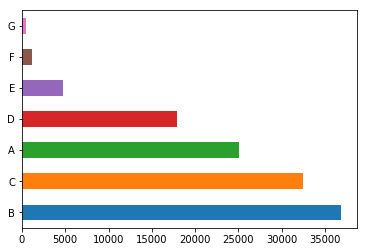

In [3]:
df.grade.value_counts().plot.barh()


#scatter plot - 2 numerical variables 
#histogram, density plot - numerical (1 column)
#barplot - everything


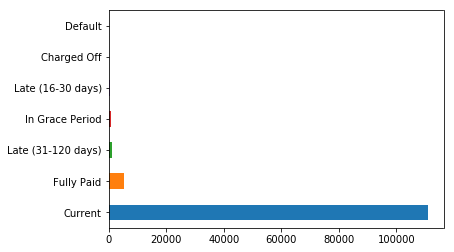

In [4]:
df.loan_status.value_counts().plot.barh()

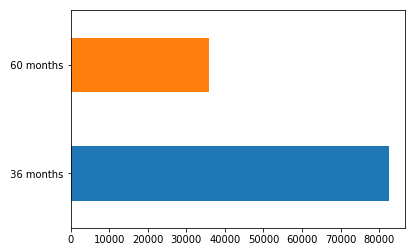

In [38]:
df.term.value_counts().plot.barh()

In [5]:
#dropping columns in bulk
df_v1 = df.drop(df.ix[:,'title':'settlement_term'].head(0).columns, axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [6]:
#dropping another set of columns
df_v2 = df_v1.drop(df.ix[:,'id':'member_id'].head(0).columns, axis=1)

In [7]:
#and dropping the last set
df_v3 = df_v2.drop(df.ix[:,'url':'desc'].head(0).columns, axis=1)

In [8]:
#taking a look at what is left
df_v3.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose
0,4800.0,4800.0,4800.0,36 months,5.32%,144.56,A,A1,Crane Operator,2 years,MORTGAGE,143000.0,Not Verified,Dec-17,Current,n,medical
1,16000.0,16000.0,16000.0,60 months,16.02%,389.26,C,C5,Technician,9 years,MORTGAGE,40000.0,Verified,Dec-17,Current,n,debt_consolidation
2,32600.0,32600.0,32600.0,36 months,11.99%,1082.64,B,B5,Admissions Advisor,< 1 year,RENT,55000.0,Source Verified,Dec-17,Current,n,house
3,10000.0,10000.0,10000.0,36 months,6.08%,304.59,A,A2,Porter,7 years,MORTGAGE,54000.0,Not Verified,Dec-17,Current,n,car
4,9000.0,9000.0,9000.0,36 months,5.32%,271.04,A,A1,District Sales Manager,10+ years,OWN,158000.0,Not Verified,Dec-17,Current,n,credit_card


In [9]:
df_v3.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc
count,118648.000000,118648.000000,118648.000000,118648.000000,1.186480e+05
mean,15317.191398,15317.191398,15311.975031,447.892756,7.876389e+04
std,9954.992577,9954.992577,9953.106377,285.414144,8.185191e+04
min,1000.000000,1000.000000,975.000000,30.120000,0.000000e+00
25%,8000.000000,8000.000000,7975.000000,239.520000,4.500000e+04
50%,12250.000000,12250.000000,12250.000000,369.000000,6.500000e+04
75%,20000.000000,20000.000000,20000.000000,602.900000,9.500000e+04
max,40000.000000,40000.000000,40000.000000,1714.540000,8.000000e+06


In [10]:
#print each unique loan status, so we can then sort them into current, late, and completed
df['loan_status'].unique()

array(['Current', 'Late (31-120 days)', 'Fully Paid', 'Late (16-30 days)',
       'In Grace Period', 'Charged Off', 'Default', nan], dtype=object)

In [11]:
#define late
late={"Late (31-120 days)":"Late (16-30 days)","Charged Off":"Default"}
late

    

{'Charged Off': 'Default', 'Late (31-120 days)': 'Late (16-30 days)'}

In [12]:
#define not late
notlate={"Current":"Fully Paid"}
notlate

{'Current': 'Fully Paid'}

In [13]:
df_v3.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose
0,4800.0,4800.0,4800.0,36 months,5.32%,144.56,A,A1,Crane Operator,2 years,MORTGAGE,143000.0,Not Verified,Dec-17,Current,n,medical
1,16000.0,16000.0,16000.0,60 months,16.02%,389.26,C,C5,Technician,9 years,MORTGAGE,40000.0,Verified,Dec-17,Current,n,debt_consolidation
2,32600.0,32600.0,32600.0,36 months,11.99%,1082.64,B,B5,Admissions Advisor,< 1 year,RENT,55000.0,Source Verified,Dec-17,Current,n,house
3,10000.0,10000.0,10000.0,36 months,6.08%,304.59,A,A2,Porter,7 years,MORTGAGE,54000.0,Not Verified,Dec-17,Current,n,car
4,9000.0,9000.0,9000.0,36 months,5.32%,271.04,A,A1,District Sales Manager,10+ years,OWN,158000.0,Not Verified,Dec-17,Current,n,credit_card


In [14]:
#combine not late statuses into one

#ifelse in order to replace values or create 2 dictionaries
not_late = ''.join(['Current', 'Fully Paid'])

In [15]:
loan_status = 'Current'
Current = loan_status.replace('Current', 'notlate')
print(notlate)

{'Current': 'Fully Paid'}


In [16]:
loan_status = 'Fully Paid'
Current = loan_status.replace('Fuly Paid', 'notlate')
print(notlate)

{'Current': 'Fully Paid'}


In [17]:
#seeing what is in the data
df_v3.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc
count,118648.000000,118648.000000,118648.000000,118648.000000,1.186480e+05
mean,15317.191398,15317.191398,15311.975031,447.892756,7.876389e+04
std,9954.992577,9954.992577,9953.106377,285.414144,8.185191e+04
min,1000.000000,1000.000000,975.000000,30.120000,0.000000e+00
25%,8000.000000,8000.000000,7975.000000,239.520000,4.500000e+04
50%,12250.000000,12250.000000,12250.000000,369.000000,6.500000e+04
75%,20000.000000,20000.000000,20000.000000,602.900000,9.500000e+04
max,40000.000000,40000.000000,40000.000000,1714.540000,8.000000e+06


In [18]:
df_v3.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose
0,4800.0,4800.0,4800.0,36 months,5.32%,144.56,A,A1,Crane Operator,2 years,MORTGAGE,143000.0,Not Verified,Dec-17,Current,n,medical
1,16000.0,16000.0,16000.0,60 months,16.02%,389.26,C,C5,Technician,9 years,MORTGAGE,40000.0,Verified,Dec-17,Current,n,debt_consolidation
2,32600.0,32600.0,32600.0,36 months,11.99%,1082.64,B,B5,Admissions Advisor,< 1 year,RENT,55000.0,Source Verified,Dec-17,Current,n,house
3,10000.0,10000.0,10000.0,36 months,6.08%,304.59,A,A2,Porter,7 years,MORTGAGE,54000.0,Not Verified,Dec-17,Current,n,car
4,9000.0,9000.0,9000.0,36 months,5.32%,271.04,A,A1,District Sales Manager,10+ years,OWN,158000.0,Not Verified,Dec-17,Current,n,credit_card


In [19]:
#dummies for loan status
loan_status = pd.get_dummies(df.loan_status, prefix='loan_status') 
print (loan_status.head(3))


   loan_status_Charged Off  loan_status_Current  loan_status_Default  \
0                        0                    1                    0   
1                        0                    1                    0   
2                        0                    1                    0   

   loan_status_Fully Paid  loan_status_In Grace Period  \
0                       0                            0   
1                       0                            0   
2                       0                            0   

   loan_status_Late (16-30 days)  loan_status_Late (31-120 days)  
0                              0                               0  
1                              0                               0  
2                              0                               0  


In [20]:
df_v3['loan_status'] = df_v3['loan_status'].replace(['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'], 'Late')

In [21]:
df_v3['loan_status'] = df_v3['loan_status'].replace(['Current', 'Fully Paid'], 'Not Late')

In [22]:
#checking out the count of each grade
df_v3.grade.value_counts()

B    36832
C    32419
A    25126
D    17866
E     4720
F     1214
G      471
Name: grade, dtype: int64

In [23]:
df_v3.loan_status.value_counts()

Not Late    116351
Late          2297
Name: loan_status, dtype: int64

In [36]:
df_v3.describe


<bound method NDFrame.describe of         loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0          4800.0       4800.0           4800.0   36 months    5.32%   
1         16000.0      16000.0          16000.0   60 months   16.02%   
2         32600.0      32600.0          32600.0   36 months   11.99%   
3         10000.0      10000.0          10000.0   36 months    6.08%   
4          9000.0       9000.0           9000.0   36 months    5.32%   
5         35000.0      35000.0          35000.0   60 months   11.99%   
6         30000.0      30000.0          30000.0   60 months   16.02%   
7          2700.0       2700.0           2700.0   36 months    9.93%   
8          8400.0       8400.0           8400.0   36 months    7.35%   
9         15000.0      15000.0          15000.0   36 months   10.42%   
10        11200.0      11200.0          11200.0   60 months   30.65%   
11         1200.0       1200.0           1200.0   36 months    7.35%   
12        35000.0      35000.0

In [24]:
num_grade = df_v3.grade.value_counts().ix

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [25]:
# frequency table for grade and whether or not someone was late
pd.crosstab(df_v3['grade'], df_v3['loan_status'], rownames=['grade']).apply(lambda x: x/x.sum(), axis=0)

loan_status,Late,Not Late
grade,,
A,0.079234,0.214386
B,0.188507,0.312838
C,0.298650,0.272735
D,0.252068,0.148576
E,0.123640,0.038126
F,0.037875,0.009686
G,0.020026,0.003653


In [26]:
# frequency table for lateness and what grade they are
pd.crosstab(df_v3['loan_status'], df_v3['grade'], rownames=['loan_status']).apply(lambda x: x/x.sum(), axis=0)
#out of all the people who were late, 

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Late,0.007243,0.011756,0.02116,0.032408,0.060169,0.071664,0.097665
Not Late,0.992757,0.988244,0.97884,0.967592,0.939831,0.928336,0.902335


In [27]:
# frequency table for lateness and whether they are a homeowner or not
pd.crosstab(df_v3['loan_status'], df_v3['home_ownership'], rownames=['loan_status']).apply(lambda x: x/x.sum(), axis=0)
#out of all the people who were late, 

home_ownership,ANY,MORTGAGE,OWN,RENT
loan_status,,,,
Late,0.0,0.016859,0.023856,0.020956
Not Late,1.0,0.983141,0.976144,0.979044


In [28]:
# frequency table for lateness and what grade they are
pd.crosstab(df_v3['loan_status'], df_v3['emp_length'], rownames=['loan_status']).apply(lambda x: x/x.sum(), axis=0)
#out of all the people who were late, 

emp_length,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
loan_status,,,,,,,,,,,
Late,0.017073,0.016962,0.018555,0.01848,0.017956,0.020583,0.018886,0.017746,0.019547,0.015735,0.024637
Not Late,0.982927,0.983038,0.981445,0.98152,0.982044,0.979417,0.981114,0.982254,0.980453,0.984265,0.975363


In [29]:
# frequency table for lateness and what grade they are
pd.crosstab(df_v3['loan_status'], df_v3['purpose'], rownames=['loan_status']).apply(lambda x: x/x.sum(), axis=0)
#out of all the people who were late, 

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation
loan_status,,,,,,,,,,,,,
Late,0.015793,0.013158,0.018718,0.0,0.023277,0.02573,0.028509,0.02799,0.035556,0.024525,0.052632,0.040188,0.02867
Not Late,0.984207,0.986842,0.981282,1.0,0.976723,0.97427,0.971491,0.97201,0.964444,0.975475,0.947368,0.959812,0.97133


In [30]:
# frequency table for lateness and what grade they are
pd.crosstab(df_v3['loan_status'], df_v3['verification_status'], rownames=['loan_status']).apply(lambda x: x/x.sum(), axis=0)
#out of all the people who were late, 

verification_status,Not Verified,Source Verified,Verified
loan_status,,,
Late,0.014004,0.019729,0.02789
Not Late,0.985996,0.980271,0.97211


In [31]:
# frequency table for lateness and what grade they are
pd.crosstab(df_v3['loan_status'], df_v3['term'], rownames=['loan_status']).apply(lambda x: x/x.sum(), axis=0)
#out of all the people who were late, 

term,36 months,60 months
loan_status,,
Late,0.01824,0.021934
Not Late,0.98176,0.978066


In [32]:
# frequency table for lateness and what grade they are
pd.crosstab(df_v3['loan_status'], df_v3['loan_amnt'], rownames=['loan_status']).apply(lambda x: x/x.sum(), axis=0)
#out of all the people who were late, 

loan_amnt,1000.0,1025.0,1050.0,1100.0,1125.0,1150.0,1175.0,1200.0,1250.0,1275.0,...,39700.0,39750.0,39775.0,39800.0,39825.0,39850.0,39900.0,39950.0,39975.0,40000.0
loan_status,,,,,,,,,,,,,,,,,,,,,
Late,0.024286,0.0,0.0,0.0,0.0,0.0,0.0,0.017167,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020481
Not Late,0.975714,1.0,1.0,1.0,1.0,1.0,1.0,0.982833,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.979519


In [33]:
x = df_v3['loan_status']
y = df_v3['loan_amnt']
colors = np.random.rand
area = (30 * np.random.rand**2)  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

TypeError: unsupported operand type(s) for ** or pow(): 'builtin_function_or_method' and 'int'